references
- https://tensorflow.blog/2016/05/30/sungjoons-tensorflow-101-deep-learning-tutorials/
- https://github.com/sjchoi86/Tensorflow-101/blob/master/notebooks/rnn_mnist_simple.ipynb
- https://tensorflow.blog/tag/examples/
- http://www.modulabs.co.kr/DeepLAB_Paper/14660
- https://github.com/golbin/TensorFlow-Tutorials

# Sequence classification with LSTM

In [1]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline 

tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trainimgs, trainlabels, testimgs, testlabels \
 = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels 
ntrain, ntest, dim, nclasses \
 = trainimgs.shape[0], testimgs.shape[0], trainimgs.shape[1], trainlabels.shape[1]
print ("MNIST loaded:", ntrain, ntest, dim, nclasses)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
MNIST loaded: 55000 10000 784 10


# We will treat the MNIST image $\in \mathcal{R}^{28 \times 28}$ as $28$ sequences of a vector $\mathbf{x} \in \mathcal{R}^{28}$.
# Our simple RNN consists of
1. One input layer which converts a $28$ dimensional input to an $128$ dimensional hidden layer,
2. One intermediate recurrent neural network (LSTM)
3. One output layer which converts an $128$ dimensional output of the LSTM to $10$ dimensional output indicating a class label.

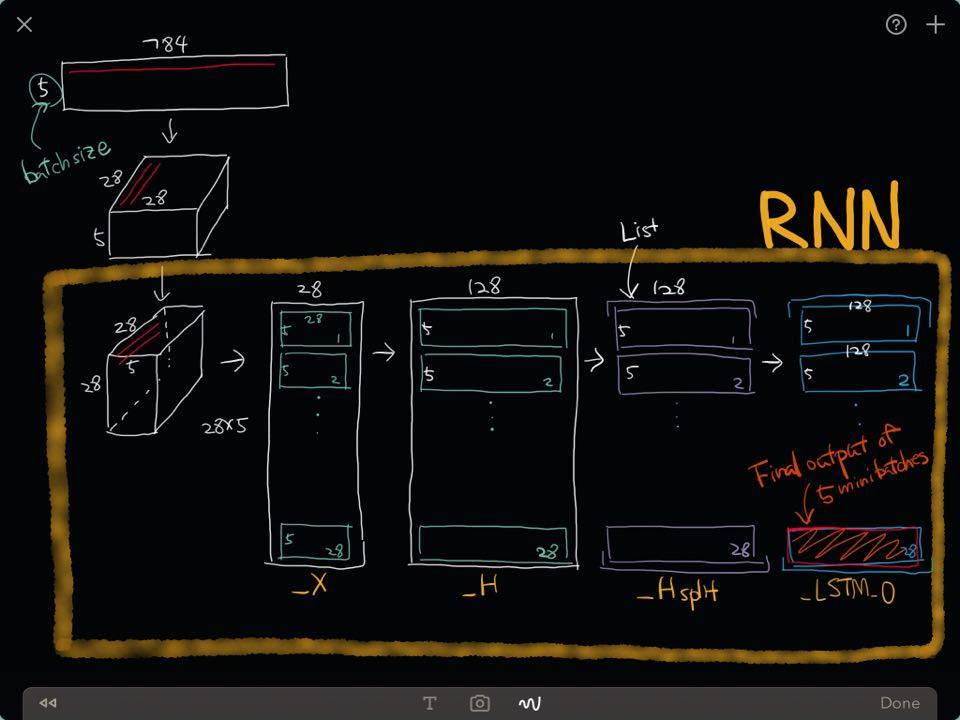

# Contruct a Recurrent Neural Network

In [2]:
diminput  = 28
dimhidden = 128
dimoutput = nclasses
nsteps    = 28
weights = {
    'hidden': tf.Variable(tf.random_normal([diminput, dimhidden])), 
    'out': tf.Variable(tf.random_normal([dimhidden, dimoutput]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([dimhidden])),
    'out': tf.Variable(tf.random_normal([dimoutput]))
}

In [3]:
def _RNN(_X, _istate, _W, _b, _nsteps, _name):
    # 1. Permute input from [batchsize, nsteps, diminput] 
    #   => [nsteps, batchsize, diminput]
    _X = tf.transpose(_X, [1, 0, 2])
    # 2. Reshape input to [nsteps*batchsize, diminput] 
    _X = tf.reshape(_X, [-1, diminput])
    # 3. Input layer => Hidden layer
    _H = tf.matmul(_X, _W['hidden']) + _b['hidden']
    # 4. Splite data to 'nsteps' chunks. An i-th chunck indicates i-th batch data 
    _Hsplit = tf.split(axis=0, num_or_size_splits=_nsteps, value=_H)
    # 5. Get LSTM's final output (_LSTM_O) and state (_LSTM_S)
    #    Both _LSTM_O and _LSTM_S consist of 'batchsize' elements
    #    Only _LSTM_O will be used to predict the output. 
    with tf.variable_scope(_name):
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=dimhidden)
        _LSTM_O, _LSTM_S = tf.nn.static_rnn(cell=lstm_cell, inputs=_Hsplit, initial_state=_istate)
    # 6. Output
    _O = tf.matmul(_LSTM_O[-1], _W['out']) + _b['out']    
    # Return! 
    return {
        'X': _X, 'H': _H, 'Hsplit': _Hsplit,
        'LSTM_O': _LSTM_O, 'LSTM_S': _LSTM_S, 'O': _O 
    }
print ("Network ready")

Network ready


# Out Network looks like this

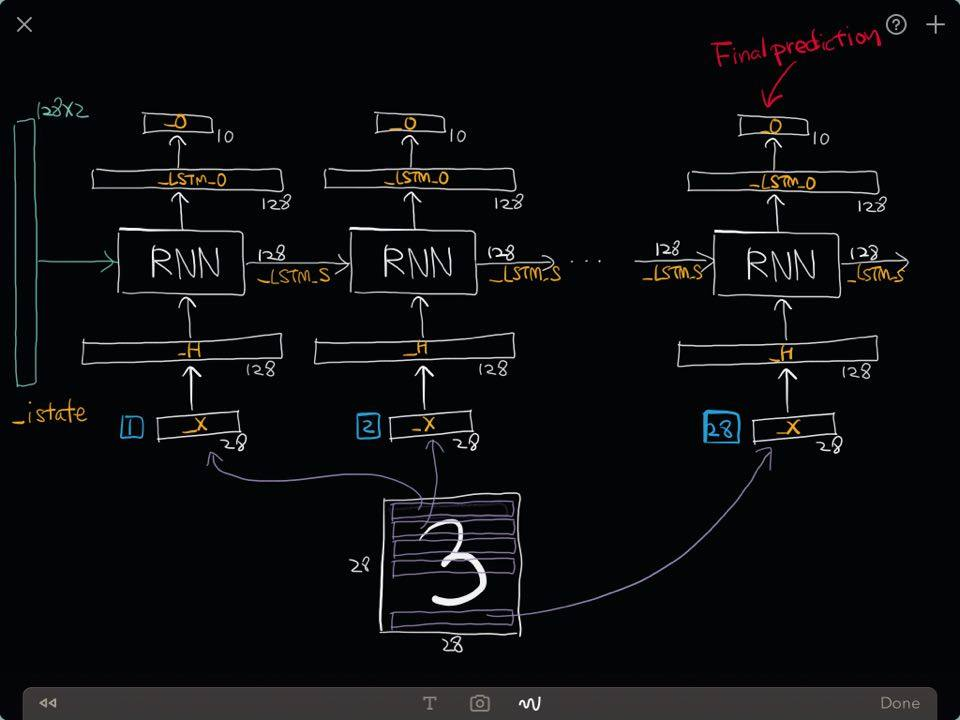

# Define functions

In [4]:
learning_rate = 0.001
x      = tf.placeholder(tf.float32, [None, nsteps, diminput])
istate = (tf.placeholder(tf.float32, [None, dimhidden]),
          tf.placeholder(tf.float32, [None, dimhidden]))
# state & cell => 2x n_hidden
y      = tf.placeholder(tf.float32, [None, dimoutput])
myrnn  = _RNN(x, istate, weights, biases, nsteps, 'basic')
pred   = myrnn['O']
cost   = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y)) 
optm   = tf.train.AdamOptimizer(learning_rate).minimize(cost) # Adam Optimizer
accr   = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred,1), tf.argmax(y,1)), tf.float32))
print ("Function Ready!")

Function Ready!


# Run!

In [5]:
training_epochs = 15
batch_size      = 128
sess = tf.Session()
sess.run(tf.global_variables_initializer())
summary_writer = tf.summary.FileWriter('logs/rnn_mnist_simple', graph=sess.graph)

for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape((batch_size, nsteps, diminput))
        # Fit training using batch data
        _, _cost = sess.run([optm, cost], feed_dict={
            x: batch_xs, y: batch_ys, istate: (
                np.zeros((batch_size, dimhidden)),
                np.zeros((batch_size, dimhidden)))})
        # Compute average loss
        avg_cost += _cost
    avg_cost /= total_batch

    print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))

print("Learning Finished")

testimgs = testimgs.reshape((ntest, nsteps, diminput))
test_acc = sess.run(accr, feed_dict={
    x: testimgs, y: testlabels, istate: (
        np.zeros((ntest, dimhidden)),
        np.zeros((ntest, dimhidden)))})
print ("accuracy: %.3f" % (test_acc))

Epoch: 000/015 cost: 0.534260896
Epoch: 001/015 cost: 0.166013542
Epoch: 002/015 cost: 0.104741459
Epoch: 003/015 cost: 0.089928907
Epoch: 004/015 cost: 0.072116391
Epoch: 005/015 cost: 0.060656746
Epoch: 006/015 cost: 0.053227778
Epoch: 007/015 cost: 0.046259151
Epoch: 008/015 cost: 0.043315892
Epoch: 009/015 cost: 0.040583432
Epoch: 010/015 cost: 0.032860814
Epoch: 011/015 cost: 0.032396291
Epoch: 012/015 cost: 0.029433443
Epoch: 013/015 cost: 0.028159913
Epoch: 014/015 cost: 0.026913550
Learning Finished
accuracy: 0.978


# What we have done so far is to feed 28 sequences of vectors $ \mathbf{x} \in \mathcal{R}^{28}$. What will happen if we feed first 25 sequences of $\mathbf{x}$?

In [6]:
# How may sequences will we use?
nsteps2     = 25

# Test with truncated inputs
testimgs = testimgs.reshape((ntest, nsteps, diminput))
testimgs_trucated = np.zeros(testimgs.shape)
testimgs_trucated[:, 28-nsteps2:] = testimgs[:, :nsteps2, :]
feeds = {x: testimgs_trucated, y: testlabels, istate: (np.zeros((ntest, dimhidden)), np.zeros((ntest, dimhidden)))}
test_acc = sess.run(accr, feed_dict=feeds)
print (" If we use %d seqs, test accuracy becomes %.3f" % (nsteps2, test_acc))

 If we use 25 seqs, test accuracy becomes 0.861


# What's going on inside the RNN?

In [7]:
# Inputs to the RNN
batch_size = 5
xtest, _ = mnist.test.next_batch(batch_size)
print ("Shape of 'xtest' is %s" % (xtest.shape,))

# Reshaped inputs
xtest1 = xtest.reshape((batch_size, nsteps, diminput))
print ("Shape of 'xtest1' is %s" % (xtest1.shape,))

# Feeds: inputs and initial states
feeds = {x: xtest1, istate: (np.zeros((batch_size, dimhidden)), np.zeros((batch_size, dimhidden)))}

# Each indivisual input to the LSTM
rnnout_X = sess.run(myrnn['X'], feed_dict=feeds)
print ("Shape of 'rnnout_X' is %s" % (rnnout_X.shape,))

# Each indivisual intermediate state
rnnout_H = sess.run(myrnn['H'], feed_dict=feeds)
print ("Shape of 'rnnout_H' is %s" % (rnnout_H.shape,))

# Actual input to the LSTM (List)
rnnout_Hsplit = sess.run(myrnn['Hsplit'], feed_dict=feeds)
print ("Type of 'rnnout_Hsplit' is %s" % (type(rnnout_Hsplit)))
print ("Length of 'rnnout_Hsplit' is %s and the shape of each item is %s" 
       % (len(rnnout_Hsplit), rnnout_Hsplit[0].shape))

# Output from the LSTM (List)
rnnout_LSTM_O = sess.run(myrnn['LSTM_O'], feed_dict=feeds)
print ("Type of 'rnnout_LSTM_O' is %s" % (type(rnnout_LSTM_O)))
print ("Length of 'rnnout_LSTM_O' is %s and the shape of each item is %s" 
       % (len(rnnout_LSTM_O), rnnout_LSTM_O[0].shape))

# Final prediction
rnnout_O = sess.run(myrnn['O'], feed_dict=feeds)
print ("Shape of 'rnnout_O' is %s" % (rnnout_O.shape,))

Shape of 'xtest' is (5, 784)
Shape of 'xtest1' is (5, 28, 28)
Shape of 'rnnout_X' is (140, 28)
Shape of 'rnnout_H' is (140, 128)
Type of 'rnnout_Hsplit' is <class 'list'>
Length of 'rnnout_Hsplit' is 28 and the shape of each item is (5, 128)
Type of 'rnnout_LSTM_O' is <class 'list'>
Length of 'rnnout_LSTM_O' is 28 and the shape of each item is (5, 128)
Shape of 'rnnout_O' is (5, 10)
